<a name="top"> <h1>3. Model Selection</h1> <a>

<p>Payments Fraud Practice<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>

<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Importación de librerias](#librerias) 


[2. Comparación de modelos](#modelos) 

[3. Carga de datos](#datos) 

[4. Creación del modelo XGBoost](#creacion) 

   
[5. Optimización del modelo](#optimizacion) 

   
[6. Predicción del modelo](#prediccion)

[7. Evaluación de las métricas del modelo](#metricas)

   - Matriz de confusión
   - Métricas: Accuracy, Recall, Precision, F1 y F2 score
   - Curva ROC
   
[8. Conclusiones Generales](#conclusiones)

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 


En este documento **realizaremos una recopilación de la métrica F2 y AUC para comparar los modelos que hemos realizado** durante este estudio. Una vez comparados, **seleccionaremos aquel que mejor score haya obtenido** y trataremos de optimizarlo ajustando las mejores métricas. 

# <a name="librerias"> 1. Importación de librerias y funciones <a> 


In [1]:
# Import basic libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Import sklearn metrics

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve,roc_auc_score, fbeta_score, make_scorer, plot_confusion_matrix
import scikitplot as skplt


# Import sklearn models and pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

# <a name="modelos"> 2. Comparación de modelos <a> 


Procedemos a crear una tabla donde podamos observar las métricas de los modelos. 

Como ya comentamos en el documento `02_DummyModel`, nuestro dataset se caracteriza por tener un desbalanceo muy grande, es por ello que el análisis de las métricas de accuracy y precisión siempre van a ser muy elevadas, sin embargo, no reflejan la realidad predictora de nuestro modelo. Por lo que nos centraremos principalmente en las métrica F2-score y AUC .

**Seleccionaremos aquella que tenga un F2 superior.Dado que para nuestro problema, nos interesa centrarnos en que trate de reconocer el mayor número de fraudes realizados, aun siendo algunos predecidos casos de no fraude.**

In [2]:
# Create a DF with the record of the F2 metric.

model_data = {'Modelo': ['Dummy', 'GLM', 'Lasso', 'Random Forest', 'Random Forest SMOTE','LightGBM','LightGBM SMOTE','Gradient' ,'SVM', 'XGBoost'],

                'F2': ['0', '0.35', '0.45', '0.66', '0.78', '0.31', '0.72', '0.81', '0.29','0.84'],
                'AUC': ['0.5', '0.95', '0.98', '0.97', '0.99', '0.66', '0.90', '0.91', '0.94','0.99']}

tabla_modelos = pd.DataFrame(model_data, columns=['Modelo', 'F2', 'AUC'])


# Print tabla_modelos

tabla_modelos.sort_values(by='F2',ascending=False).set_index("Modelo")

,F2,AUC
Modelo,,
XGBoost,0.84,0.99
Gradient,0.81,0.91
Random Forest SMOTE,0.78,0.99
LightGBM SMOTE,0.72,0.90
Random Forest,0.66,0.97
Lasso,0.45,0.98
GLM,0.35,0.95
LightGBM,0.31,0.66
SVM,0.29,0.94


Como vemos reflejado en la tabla, **el modelo que mejor se ha comportado ha sido el XGBoost**. Es por ello que procederemos a optimizarlo y a obtener las predicciones de la función de test.

# <a name="datos"> 3. Carga de datos <a> 

Para la optimización del modelo, procederemos a cargar las funciones que usaremos, el set de train y validación juntos y el set de test, para predecir los datos sobre el.

In [3]:
# Import the functions to use in the notebook.

from aux_functions import load_model, save_model

def f2_func(y_true, y_pred):
    f2_score = fbeta_score(y_true, y_pred, beta=2)
    return f2_score

#Load the preprocessor

preprocessor = load_model('../models/preprocessor.pickle')

# Load the train dataset separated by other variables and target. Taking into account that the first column is the index.

x_train_all = pd.read_csv("../data/processed/x_train_all.csv",index_col=0 )
y_train_all = pd.read_csv("../data/processed/y_train_all.csv",index_col=0 )

# Load the test dataset separated by other variables and target. Taking into account that the first column is the index.

x_test = pd.read_csv("../data/processed/x_test.csv",index_col=0 )
y_test = pd.read_csv("../data/processed/y_test.csv",index_col=0 )

# <a name="creacion"> 4. Creación del modelo XGBoost <a> 

Creamos el Pipeline del modelo, con el preprocesado y el algoritmo en su interior.

In [4]:
# Design the parameters.

n_jobs = -1
random_state = 12345

# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

xgb_model_test = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', XGBClassifier(n_jobs=n_jobs, random_state=random_state)
    )
])


# <a name="optimizacion"> 5. Optimización del modelo <a> 

Para optimizar el modelo realizaremos pruebas con diferentes hiperparámetros y nos quedaremos con aquellos que mejor F2 score nos devuelva.

In [48]:
# A parameter grid for XGBoost
params = {
        'clasificador__max_depth': [2, 5, 7],
        'clasificador__verbosity': [0, 1, 2,3],
        
        }

In [ ]:
# Search the best model with the grid created before.

random_state = 12345
scoring=make_scorer(f2_func)
n_jobs= -1

search = GridSearchCV(xgb_model_test, params,scoring=scoring)
search.fit(x_train_all, y_train_all)

In [9]:
# Save backup of the best grid.

save_model(search,'../models/search.pickle')

Observamos los parametors y score resultantes:

In [50]:
# Print best grid.

print(search.best_params_)    
print(search.best_score_)

{'clasificador__max_depth': 5, 'clasificador__verbosity': 0}
0.8539140354976057


Observamos que utilizando los parametros anteriores logramos subir un punto más el F2 score, **es por ello que los aplicaremos para predecir sobre el set de test**. Este modelo con aún más parámetros en la optimización y mayor tiempo de cómputo, seguramente se pueda mejorar más.

In [60]:
# Design the parameters.

n_jobs = -1
random_state = 12345
max_depth = 5
verbosity = 0
# Create a pipeline that applies a preprocess of the data and then the LogisticRegression model.

xgb_model_test = Pipeline([
    ('preprocessor', preprocessor),
    ('clasificador', XGBClassifier(n_jobs=n_jobs, random_state=random_state, max_depth=max_depth, verbosity=verbosity)
    )
])


In [62]:
# Optimization of the xgboost_model with the train set: input and target data. 

xgb_model_test.fit(x_train_all, y_train_all)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='unknow',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type', 'gender', 'device',
                                                   'zone', 'security_alert',
                                                   'nameDest', 'nameOrig',
                                                   'nameDest']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
         

In [67]:
# Save the backup of the XGB optimziation as a pickle file.

save_model(xgb_model_test,'../models/xgb_model_test.pickle')

**Para evitar optimizar de nuevo el modelo, ejecutar a partir de la celda que aparece a continuación.**

In [68]:
# Load the XGB model already fitted in /models.

xgb_model_test = load_model('../models/xgb_model_test.pickle')


# <a name="prediccion"> 6. Predicción del modelo <a> 

In [69]:
# Predict the target value of the validation set.

predictions = xgb_model_test.predict(x_test)

# Predict the probabilities of the target value for the validation set.

predict_probabilities = xgb_model_test.predict_proba(x_test)

# <a name="metricas"> 7. Evaluación de las métricas del modelo <a> 

### 7.1. Matriz de confusión

Confusion matrix, without normalization
[[261854      4]
 [    55    231]]
Normalized confusion matrix
[[9.99984725e-01 1.52754546e-05]
 [1.92307692e-01 8.07692308e-01]]


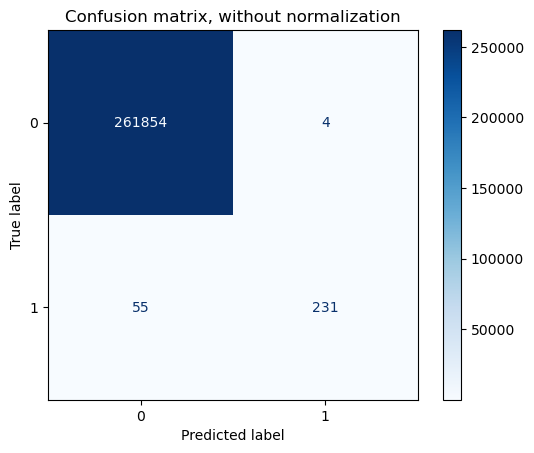

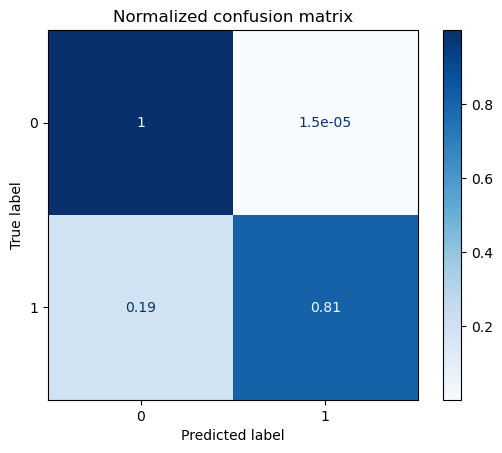

In [70]:
# List with the titles and parameters

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

# Plot the confusion matrix

for title, normalize in titles_options:
    disp = plot_confusion_matrix(xgb_model_test, x_test, y_test,
                                 # display_labels=ytest,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Sobre el set de test, mantiene unos resultados similares al estudiado en `2.8.XGBoost`, llega a cometer un fallo del 19% y un acierto del 81%, lo consideramos un resultado bueno, aunque no perfecto.

### 7.2. Métricas: Accuracy, Recall, Precision, F1 score

In [56]:
# Print the general metrics.

print(classification_report(y_test, predictions))

# Print the F2 score.

print('F2 score is ' +str(fbeta_score(y_test, predictions, average='binary', beta=2)))

# Model Accuracy

print("Accuracy:",metrics.accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    261858
           1       0.98      0.81      0.89       286

    accuracy                           1.00    262144
   macro avg       0.99      0.90      0.94    262144
weighted avg       1.00      1.00      1.00    262144

F2 score is 0.8375634517766497
Accuracy: 0.9997749328613281


Como vemos el F2 score se comporta muy similar al estudiado sobre el set de train.

### 7.3. Curva ROC

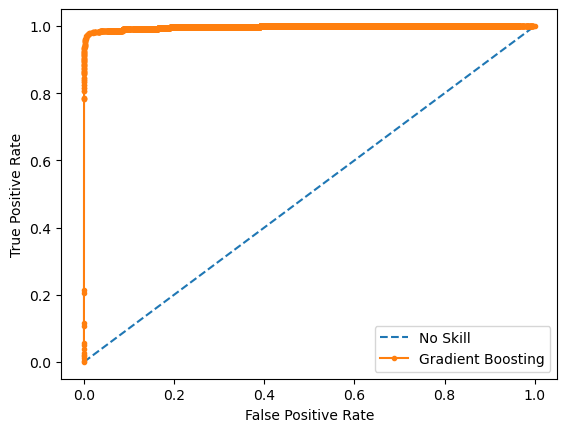

The Compute Area Under the Receiver Operating Characteristic is 0.9966809401369353


In [57]:
# Keep probabilities for the positive outcome only
yhat = predict_probabilities[:, 1]
# Calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# Plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Gradient Boosting')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# Show the plot
plt.show()

# Display the ROC AUC.

print('The Compute Area Under the Receiver Operating Characteristic is '+ str(metrics.roc_auc_score(y_test,yhat)))

En cuanto al AUC, es bastante alto con un 99.6% por lo que nuestro modelo es funcional.

# <a name="conclusiones"> 8. Conclusiones Generales <a> 

**- Para la elección del modelo nos hemos basado principalmente en el score F2, seguido del AUC, dado el gran desbalanceo que tiene nuestro dataset.**

**- El modelo que mejor se ha comportado basandonos en las métricas ha sido el XGBoost.**

**- Durante la realización de optimización hemos conseguido mejorarlo un punto más, sin embargo, contando con mayor tiempo de computación e introduciendo más parametros, estamos seguros de que podría mejorar considerablemente.**

**- Los resultados del modelo optimizado para el set de train han sido los esperados. Han sido muy similares a los de validación, por lo que descartamos que haya habido overfitting y declaramos el modelo como funcional.**

[Ir arriba del documento](#top)